In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle
import tensorflow as tf
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import seaborn as sns


#Load sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#Learning curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from IPython.display import display_html
import warnings

# for inline plots
%matplotlib inline
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 2)

In [2]:
test_path ="../../data/Preprocess _Results/Test"
train_path ="../../data/Preprocess _Results/Train"

image_size=(128,128,3)

In [3]:
category_list = os.listdir(train_path)
category_list

['DME', 'Normal']

In [4]:
number_of_classes= len(category_list)

# get the images and vertical projection

In [5]:
def get_vertical_projection(img_dir):
  img = cv2.imread(img_dir)
  ret, bw_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
  X_data = []
  Y_data = []
  x,y,c = bw_img.shape
  for Y in range(y):
    for X in range(x):
        if bw_img[X][Y][0] == 255:
              X_data.append(Y)
              Y_data.append(x - X)
              break
  return X_data, Y_data


In [6]:
def get_image_list(path, categories):
    images=[]
    class_num=[]
    x_proj = []
    y_proj = []
    projection_data = []
    poly_coeff = []
    for cat in (categories):
        img_list = os.listdir(path +'/'+cat)
        for img in tqdm(img_list):
            im = cv2.imread(path +'/'+cat+"/"+img)
            im = cv2.resize(im, (image_size[0], image_size[1]))
            images.append(im)
            class_num.append(categories.index(cat))

            X_data,Y_data = get_vertical_projection(path +'/'+cat+"/"+img)
            poly = np.polyfit(X_data, Y_data , deg= 10)
            poly_coeff.append(np.array(poly))

            # x_proj.append(X_data)
            # y_proj.append(Y_data)
            
            # projection_data.append([X_data, Y_data])
    # return images, class_num, x_proj, y_proj, projection_data
    return images, class_num, poly_coeff

In [7]:
train_img_X, train_img_Y, poly_coeff_train = get_image_list(train_path, ['Normal',"DME"])
val_img_X, val_img_Y, poly_coeff_val = get_image_list(test_path, ['Normal',"DME"])

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 16.49it/s]


In [8]:
print(len(train_img_X), len(train_img_Y), len(val_img_X), len(val_img_Y), len(poly_coeff_train), len(poly_coeff_val)  )

2229 2229 84 84 2229 84


# Get test set 
- current test set used as validation set

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(poly_coeff_train, train_img_Y, test_size=0.2, random_state=42)

In [10]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(poly_coeff_val)
y_val = np.array(val_img_Y)

In [11]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(1783, 11) (1783,)
(446, 11) (446,)
(84, 11) (84,)


# Model definition

In [12]:
classes = category_list
cv = ShuffleSplit(n_splits = 100, test_size = 0.25, random_state = 0)
train_size = np.linspace(.1, 1.0, 15)
cmap = 'viridis'

In [13]:
    
# Learning curve
def LearningCurve(X, y, model, cv, train_sizes):

    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = 4, 
                                                            train_sizes = train_sizes)

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std  = np.std(train_scores, axis = 1)
    test_scores_mean  = np.mean(test_scores, axis = 1)
    test_scores_std   = np.std(test_scores, axis = 1)
    
    train_Error_mean = np.mean(1- train_scores, axis = 1)
    train_Error_std  = np.std(1 - train_scores, axis = 1)
    test_Error_mean  = np.mean(1 - test_scores, axis = 1)
    test_Error_std   = np.std(1 - test_scores, axis = 1)

    Scores_mean = np.mean(train_scores_mean)
    Scores_std = np.mean(train_scores_std)
    
    _, y_pred, Accuracy, Error, precision, recall, f1score,Acc_score = ApplyModel(X, y, model)
    
    plt.figure(figsize = (16,8))
    plt.subplot(1,2,1)
    ax1 = Confuse(y, y_pred, classes)
    plt.subplot(1,2,2)
    plt.fill_between(train_sizes, train_Error_mean - train_Error_std,train_Error_mean + train_Error_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_Error_mean - test_Error_std, test_Error_mean + test_Error_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_Error_mean, 'o-', color = "r",label = "Training Error")
    plt.plot(train_sizes, test_Error_mean, 'o-', color = "g",label = "Cross-validation Error")
    plt.legend(loc = "best")
    plt.grid(True)
     
    return (model, Scores_mean, Scores_std )

def ApplyModel(X, y, model):
    
    model.fit(X, y)
    y_pred  = model.predict(X)

    Accuracy = round(np.median(cross_val_score(model, X, y, cv = cv)),2)*100
    Error   = 1 - Accuracy
    
    precision = precision_score(y_train, y_pred) * 100
    recall = recall_score(y_train, y_pred) * 100
    f1score = f1_score(y_train, y_pred) * 100
    Acc_score = accuracy_score(y_train, y_pred,normalize=True) * 100
    
    return (model, y_pred, Accuracy, Error, precision, recall, f1score,Acc_score )  
    
def Confuse(y, y_pred, classes):
    cnf_matrix = confusion_matrix(y, y_pred)
    
    cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis = 1)[:, np.newaxis]
    c_train = pd.DataFrame(cnf_matrix, index = classes, columns = classes)  

    ax = sns.heatmap(c_train, annot = True, cmap = cmap, square = True, cbar = False, 
                          fmt = '.2f', annot_kws = {"size": 20})
    return(ax, c_train)

def PrintResults(model, X, y, title):
    
    model, y_pred, Accuracy, Error, precision, recall, f1score, Acc_score = ApplyModel(X, y, model)
    
    _, Score_mean, Score_std = LearningCurve(X, y, model, cv, train_size)
    Score_mean, Score_std = Score_mean*100, Score_std*100
    
    
    print('Scoring Accuracy: %.2f %%'%(Accuracy))
    print('Scoring Mean: %.2f %%'%(Score_mean))
    print('Scoring Standard Deviation: %.4f %%'%(Score_std))
    print("Precision: %.2f %%"%(precision))
    print("Recall: %.2f %%"%(recall))
    print('f1-score: %.2f %%'%(f1score))
    print('accuracy: %.2f %%'%(Acc_score))
  
    Summary = pd.DataFrame({'Model': title,
                       'Accuracy': Accuracy, 
                       'Score Mean': Score_mean, 
                       'Score St Dv': Score_std, 
                       'Precision': precision, 
                       'Recall': recall, 
                        'F1-Score': f1score,
                        "accuracy":Acc_score,}, index = [0])
    return (model, Summary)



def plot_conf_matrix(y_train_pred, y_train, y_test_pred, y_test, y_val_pred, y_val):
    cm = confusion_matrix(y_train_pred, y_train)
    plt.figure(figsize=(25,6))
    plt.subplot(1,3,1)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for train')
    Accuracy = (cm[0][0] + cm[1][1])/ sum(sum(cm)) *100
    print("Train Accuracy ", Accuracy)
    
    cm = confusion_matrix(y_test_pred, y_test)
    plt.subplot(1,3,2)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for test')
    Accuracy = (cm[0][0] + cm[1][1])/ sum(sum(cm)) *100
    print("Test Accuracy ", Accuracy)

    cm = confusion_matrix(y_val_pred, y_val)
    plt.subplot(1,3,3)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for val')
    Accuracy = (cm[0][0] + cm[1][1])/ sum(sum(cm)) *100
    print("Val Accuracy ", Accuracy)

In [14]:
model_rf_final = XGBClassifier(
    learning_rate =0.1,
    n_estimators=150, max_depth=6,
    min_child_weight=1, gamma=0, 
    subsample=0.8,colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=1,seed=27)

Scoring Accuracy: 77.00 %
Scoring Mean: 98.78 %
Scoring Standard Deviation: 0.3417 %
Precision: 96.93 %
Recall: 98.04 %
f1-score: 97.48 %
accuracy: 97.25 %


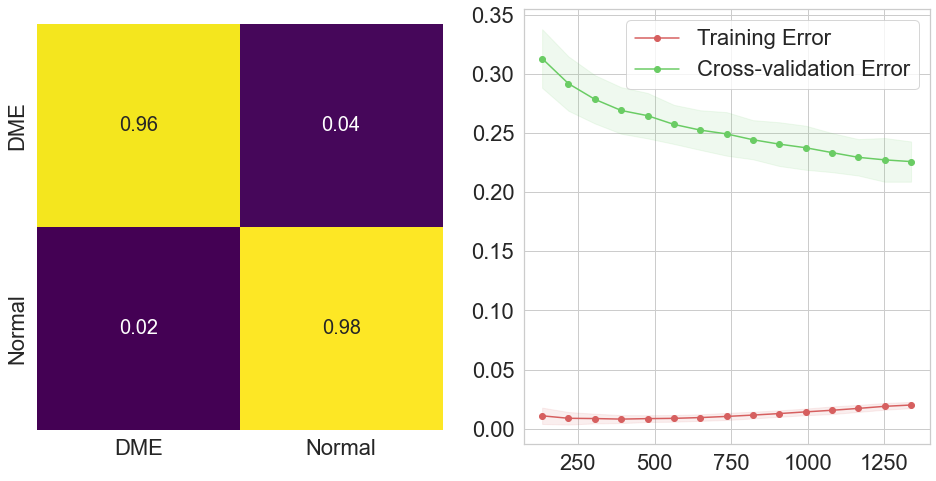

In [15]:
_, Summary_LR = PrintResults(model_rf_final, x_train, y_train, 'XGB')
y_train_pred = model_rf_final.predict(x_train)
y_test_pred =model_rf_final.predict(x_test)
y_val_pred = model_rf_final.predict(x_val)

Train Accuracy  97.25182277061133
Test Accuracy  73.09417040358744
Val Accuracy  82.14285714285714


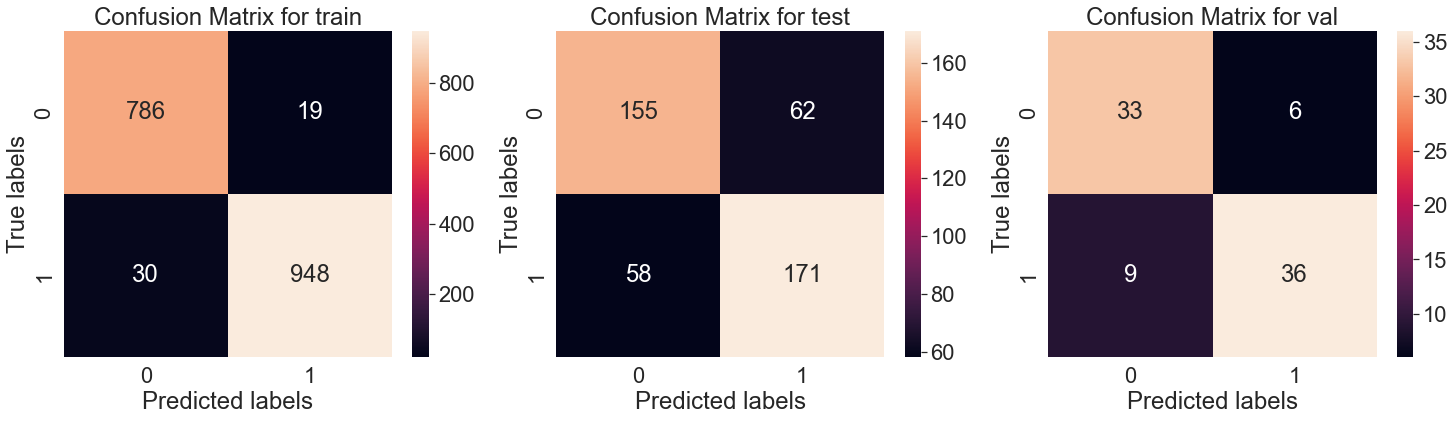

In [16]:
plot_conf_matrix(y_train_pred, y_train, y_test_pred, y_test, y_val_pred, y_val )

In [20]:
filename = 'finalized_model.sav'
pickle.dump(model_rf_final, open(filename, 'wb'))